In [1]:
import csv
import datetime
import geopandas as gpd
import numpy as np
import rasterio as rio
from rasterio.mask import mask
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from scipy.integrate import simps
from scipy import integrate



In [2]:

# Open the raster file
file_path = '/Users/niks/Downloads/flexfit_ndvi.T13TEF.2016.bin'

no_data_value = -9999  # Set this to the correct NoData value for your raster

# Open the shapefile
shapefile_path = '/Users/niks/Downloads/cper_pastures_2022_w_exclosures_spk.shp'
pastures = gpd.read_file(shapefile_path)


#load ground data (PAR) Apex_data_par.csv
apex_data = pd.read_csv('/Users/niks/Downloads/Apex_data_par.csv')

#for testing, we load only a specific pasture
specific_pasture = pastures[pastures['Past_Name_'] == '15E']
# Convert the GeoDataFrame to a format that rasterio can understand (GeoJSON-like dict)
geometries = specific_pasture.geometry.values[0]
geometries = [mapping(geometries)]

# Open the raster file with rasterio
with rio.open(file_path) as src:
    # Crop the raster file to the shapefile
    out_image, out_transform = mask(src, geometries, crop=True)
    out_meta = src.meta.copy()

In [3]:
#calculate NVDI
def calc_nvdi(out_image, no_data_value):
    """
    Function to calculate the average NDVI for all bands and convert band number to dates.
    :param out_image: Numpy array of image data with all bands.
    :param no_data_value: Value representing no data in the array.
    :return: List of dates and corresponding average NDVI for all bands.
    """
    num_bands = out_image.shape[0]
    average_ndvi_list = []
    date_list = []
    start_date = datetime.date(2016, 1, 1)  # start date of 2016
    
    for band_number in range(num_bands):
        band_data = out_image[band_number]
        valid_pixels = band_data[band_data != no_data_value]
        average_ndvi_list.append(np.mean(valid_pixels))
        
        # Convert band number to date
        current_date = start_date + datetime.timedelta(days=band_number)
        date_list.append(current_date)
    
    return date_list, average_ndvi_list

/Users/niks/opt/anaconda3/envs/prince/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/niks/opt/anaconda3/envs/prince/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


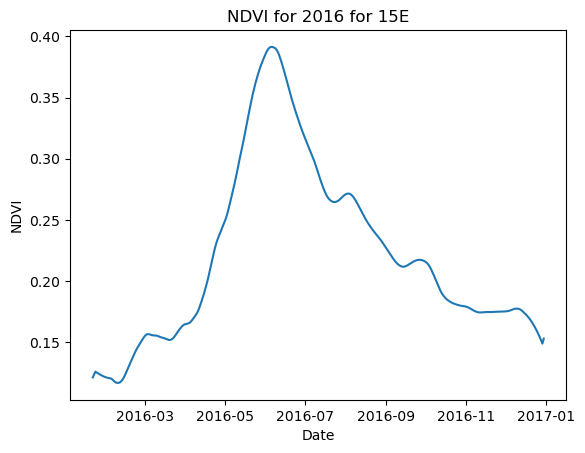

In [4]:
date_list, average_ndvi_list = calc_nvdi(out_image, no_data_value)

#plot NVDI
plt.plot(date_list, average_ndvi_list)
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('NDVI for 2016 for 15E')
plt.show()


In [5]:
sos_date = datetime.date(2016, 1, 1)
# Set the clip date
clip_date = datetime.date(2016, 8, 4)

start_index = date_list.index(sos_date)
end_index = date_list.index(clip_date)

In [6]:
#calculating FPAR
sr_list = [(1 + ndvi) / (1 - ndvi) for ndvi in average_ndvi_list]
#remove nan values
sr_list2 = [x for x in sr_list if not np.isnan(x)]

#min = 1.1
#max = 11.62
#or min of 1.55 from Rowan 

#find max and min
SRmax= max(sr_list2)
SRmin = min(sr_list2)


#FPAR calculation as per Gafney et al 2007
fpar_list = [min(sr / (SRmax - SRmin) - SRmin / (SRmax - SRmin), 0.95) for sr in sr_list]

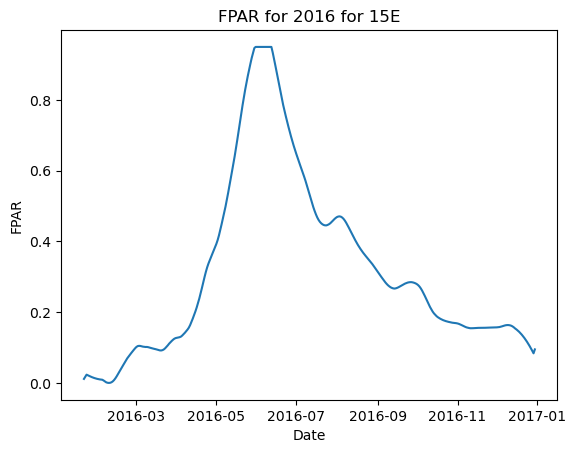

In [7]:
#plot FPAR
plt.plot(date_list, fpar_list)
plt.xlabel('Date')
plt.ylabel('FPAR')
plt.title('FPAR for 2016 for 15E')
plt.show()


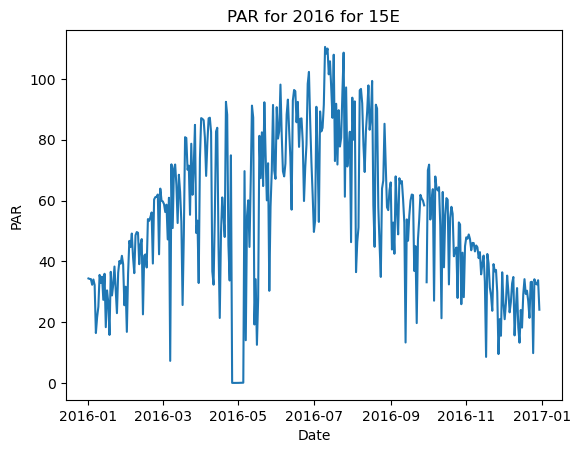

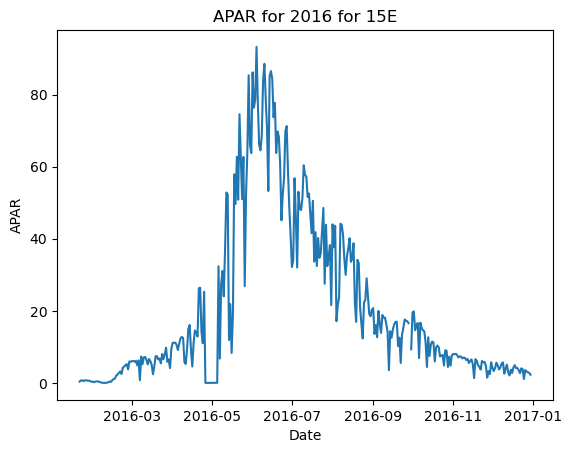

In [9]:
par_list = []
apar_list = []

apex_data['TimeStamp'] = pd.to_datetime(apex_data['TimeStamp'])

# Converting date_list to datetime objects for easy comparison
date_list2 = [pd.to_datetime(date) for date in date_list]

#calculate PAR from apex data
# Looping through each date in date_list
for i, current_date in enumerate(date_list2):
    # Check if current_date exists in the apex_data DateTime column AND pastureID = 15E
    matching_row = apex_data[apex_data['TimeStamp'] == current_date]
    if not matching_row.empty:
        # If the date exists, get the PAR value for that date from 'PAR_total_micomolPerSecPerMetSqd' column
        par_value = matching_row['PAR_total_micomolPerSecPerMetSqd'].values[0]

        par_value = par_value * 0.2174
        
        par_value = par_value * (24 * 60 * 60) / (10e6)
        #add to list
        par_list.append(par_value)
    
        # Get the corresponding fPAR value
        fpar_value = fpar_list[i]
        # Multiply PAR and fPAR, and add the result to the apar_list
        apar_list.append(par_value * fpar_value)


#plot PAR
plt.plot(date_list2, par_list)
plt.xlabel('Date')
plt.ylabel('PAR')
plt.title('PAR for 2016 for 15E')
plt.show()

#plot APAR
plt.plot(date_list2, apar_list)
plt.xlabel('Date')
plt.ylabel('APAR')
plt.title('APAR for 2016 for 15E')
plt.show()



In [18]:
#calculate median apar between 1/1 and 1/30 
start_index = date_list.index(datetime.date(2016, 1, 2))
end_index = date_list.index(datetime.date(2016, 1, 30))
#find median apar between 1/1 and 1/30 where apar is not nan
median_apar = np.median([apar for apar in apar_list[start_index:end_index] if not np.isnan(apar)])
print('Median APAR between 1/1 and 1/30: {}'.format(median_apar))

Median APAR between 1/1 and 1/30: 0.6451656263106201


In [14]:
date_list_datetime = pd.to_datetime(date_list)

start_integration_date = pd.to_datetime('2016-03-01')
end_integration_date = pd.to_datetime('2016-12-31')

#print index of NaN values and corresponding date
for i, date in enumerate(date_list_datetime):
    if start_integration_date <= date <= end_integration_date:
        if np.isnan(apar_list[i]):
            print(i, date)
            #save the date
            nandate = []
            nandate.append(date)

# Select the APAR values between the start and end dates
selected_apar_values = [apar_list[i] for i, date in enumerate(date_list_datetime) 
                        if start_integration_date <= date <= end_integration_date]

selected_dates = [date for date in date_list_datetime 
                  if start_integration_date <= date <= end_integration_date]

#if date is in nandate, remove from selected dates
selected_dates = [date for date in selected_dates if date not in nandate]

# Ensure there are no NaN values
selected_apar_values = [x for x in selected_apar_values if not np.isnan(x)]

x_vals = [date.dayofyear for date in selected_dates]


272 2016-09-29 00:00:00


Cumulative Integral of APAR values: 7064.351273457812
Cumulative Integral of APAR values minus median apar: 7063.706107831501


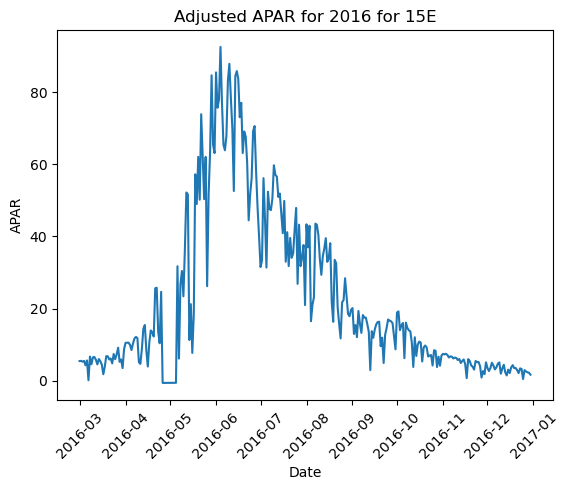

In [26]:
cumulative_integral = integrate.cumtrapz(x=x_vals, y=selected_apar_values, initial=0)

print('Cumulative Integral of APAR values:', cumulative_integral[-1])

#recaclulate cumulative integral substracting median apar
cumulative_integral = integrate.cumtrapz(x=x_vals, y=selected_apar_values, initial=0) - median_apar

print('Cumulative Integral of APAR values minus median apar:', cumulative_integral[-1])

#plot apar values with integral from 3/1 to 12/31
plt.plot(selected_dates, selected_apar_values- median_apar)
plt.xlabel('Date')
plt.ylabel('APAR')
plt.title('Adjusted APAR for 2016 for 15E')
#rotate x axis labels
plt.xticks(rotation=45)
#plot cumulative integral
plt.show()


